# Fitting categorical mixtures: example

In this simple intro example, we use a dataset of aligned protein sequences
similar to green fluorescent protein (GFP). This is a very small dataset
(< 400 sequences) but will suffice to illustrate how to use the package
for a variety of tasks. You'll need to have seaborn, numpy, scipy
and of course categorical_mixture installed.

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from categorical_mix.categorical_mix import CategoricalMixture

#Change this filepath to the location of the test data, which comes with the package
#or can be retrieved from the github.
if "test_data" not in os.listdir():
    os.chdir(os.path.join("..", "..", "tests"))

x = np.load(os.path.join("test_data", "encoded_test_data.npy"))

We could also use the absolute filepath to the .npy file and make it
into a single item list then supply this to the fit function instead,
e.g. x = [filepath], with the same result. Supplying a list of .npy
files is preferable if the dataset is large. In this case it's
very small so working with data in memory is preferable.

Next, we'll evaluate the BIC (Bayes Information Criterion) and AIC
(Akaike Information Criterion) for different numbers of clusters,
using 3 restarts for each to boost our chances of finding the global
maximum for that setting. BIC tends to be more conservative and
prefer smaller numbers of clusters than AIC. Using 2 threads,
this took < 1 second for the whole procedure on our machine. We
typically find we're able to cluster 1 million sequences using 3
threads with 10 clusters in < 2 minutes. Much larger datasets &
numbers of clusters can be fitted if needed using multiprocessing
& multithreading on a cluster.

In [4]:
cluster_nums = [1,2,3,4,5,6,7,8,9,10]
bics, aics = [], []

import time
st = time.time()

for cnum in cluster_nums:
    cat_mix = CategoricalMixture(n_components=cnum, num_possible_items=21,
                                sequence_length=408)
    cat_mix.fit(x, max_iter=150, n_restarts=3, random_state=123,
               n_threads=2)
    bics.append(cat_mix.BIC(x))
    aics.append(cat_mix.AIC(x))
    
end_time = time.time()
print(f"NET TIME: {end_time - st} seconds")

Loss: -1365.7865006348986
Loss: -333.13034844952085
Loss: -333.13034844952085
Iterations: 2****************

Loss: -1366.6456827048314
Loss: -333.13034844952085
Loss: -333.13034844952085
Iterations: 2****************

Loss: -1386.915257650904
Loss: -333.13034844952085
Loss: -333.13034844952085
Iterations: 2****************

Loss: -1356.6538069807223
Loss: -286.6716162122001
Loss: -282.69114213097686
Loss: -281.99473155420225
Loss: -281.99473155420225
Iterations: 4****************

Loss: -1346.7154079990512
Loss: -312.12870079986254
Loss: -300.1584058822222
Loss: -298.1603392453466
Loss: -297.36863778336465
Loss: -297.22289577372453
Loss: -297.0515850075373
Loss: -296.68928237993816
Loss: -296.6892823798981
Iterations: 8****************

Loss: -1363.4022035617145
Loss: -326.41137745139974
Loss: -325.34486847661384
Loss: -325.344818717917
Iterations: 3****************

Loss: -1354.5147377391977
Loss: -289.68031841367286
Loss: -280.7262811662879
Loss: -280.07404435290937
Loss: -279.978617

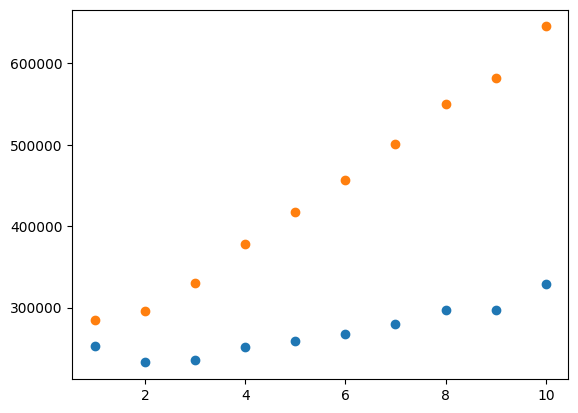

In [5]:
plt.scatter(cluster_nums, aics)
plt.scatter(cluster_nums, bics)

As expected, BIC is more conservative. Both metrics suggest 2 clusters is a good
number; AIC suggests 3 might also be acceptable.

In [6]:
cat_mix = CategoricalMixture(n_components=3, num_possible_items=21,
                                sequence_length=408)
#We'll use a slightly more restrictive tol here. 1e-3 is usually
#fine, but 1e-4 may mean slightly better results.
cat_mix.fit(x, max_iter=150, n_restarts=5, random_state=123, tol=1e-4,
               n_threads=2)

Loss: -1354.5147377391977
Loss: -289.68031841367286
Loss: -280.7262811662879
Loss: -280.07404435290937
Loss: -279.97861718569493
Loss: -279.7838312324361
Loss: -279.7838312324362
Iterations: 6****************

Loss: -1358.3054239109604
Loss: -283.9602604280931
Loss: -274.45148361892984
Loss: -272.89214194877496
Loss: -271.93370401050436
Loss: -270.5669765857053
Loss: -269.131786789243
Loss: -267.019824864162
Loss: -264.77175095790466
Loss: -263.68305642712085
Loss: -263.2659139078803
Loss: -263.2659139078803
Iterations: 11****************

Loss: -1327.4231433589573
Loss: -307.5550607729907
Loss: -284.96580373701255
Loss: -280.9254227532711
Loss: -278.51718973119796
Loss: -276.42684942488324
Loss: -274.2372873387544
Loss: -273.2124239894817
Loss: -272.7997276066061
Loss: -272.33534101655005
Loss: -272.33534101655005
Iterations: 10****************

Loss: -1334.6050132784205
Loss: -303.16925860353683
Loss: -275.57310475206634
Loss: -274.0153396379866
Loss: -273.1049602036435
Loss: -272.50

Next, we'll score the training set, i.e. get the probability of each
input datapoint given the fitted model, to see what the distribution
of datapoint scores looks like. Then, we'll contrast this with
some sequences that are most definitely not from this dataset (decoys).
The decoys were generated by taking one of the sequences in the training
dataset and randomly mutating it at roughly 1 in 10 positions.

In [7]:
decoys = np.load(os.path.join("test_data", "decoys.npy"))

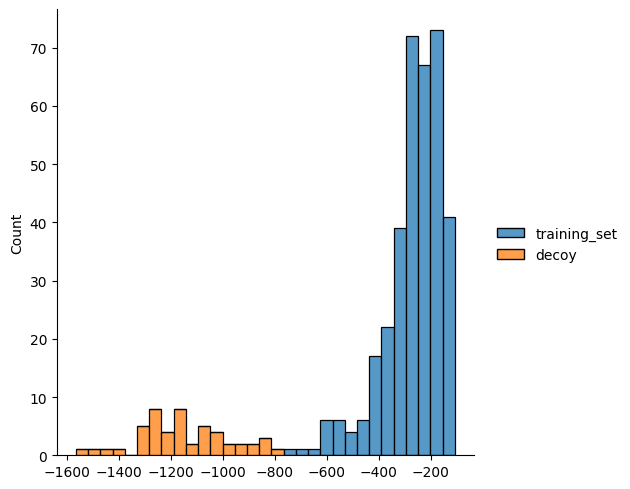

In [8]:
train_scores = cat_mix.score(x)
decoy_scores = cat_mix.score(decoys)
all_scores = np.concatenate([train_scores, decoy_scores])
labels = ["training_set" for i in train_scores.tolist()] + \
    ["decoy" for i in decoy_scores.tolist()]
sns.displot(x=all_scores, hue=labels, multiple="stack")

Remarkably, we can see that even though the decoys are mutants of
one of the sequences in the training set, the model can easily
distinguish them. That's because the mutants are substantially different
(on average, a random mutation every 10 positions).

Now let's assign the training data sequences to clusters.

In [9]:
clust_preds = cat_mix.predict(x)
print(f"There are {np.sum(clust_preds==0)} sequences in cluster 1, "
      f"{np.sum(clust_preds==1)} in cluster 2, "
      f"{np.sum(clust_preds==2)} in cluster 3")

There are 15 sequences in cluster 1, 113 in cluster 2, 228 in cluster 3


Each cluster is a distribution across sequence space. Let's see what these clusters look
like. The class attribute "mu_mix" stores the probability of each element at
each position for each cluster. We can plot each full matrix, but they're rather large
(408 x 21), so let's narrow down on an arbitrary region.

In [12]:
AA_LIST = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "-"]

def implot(mu_vals, cnum, ymin, ymax, color = "Reds"):
    fig = plt.figure(figsize=(10,5))
    cleaned_mu = mu_vals.copy()
    #Very low values should be plotted as blank.
    cleaned_mu[cleaned_mu <= 1e-14] = np.nan
    plt.imshow(cleaned_mu.T[:,ymin:ymax], aspect="auto", cmap=color, vmin=0, vmax=1,
              interpolation="none")
    plt.ylabel("Amino acid position (# from 0)")
    plt.xlabel("Amino acid")
    plt.yticks(np.arange(21), AA_LIST)
    plt.colorbar()
    plt.title(f"Cluster {cnum}")
    return fig

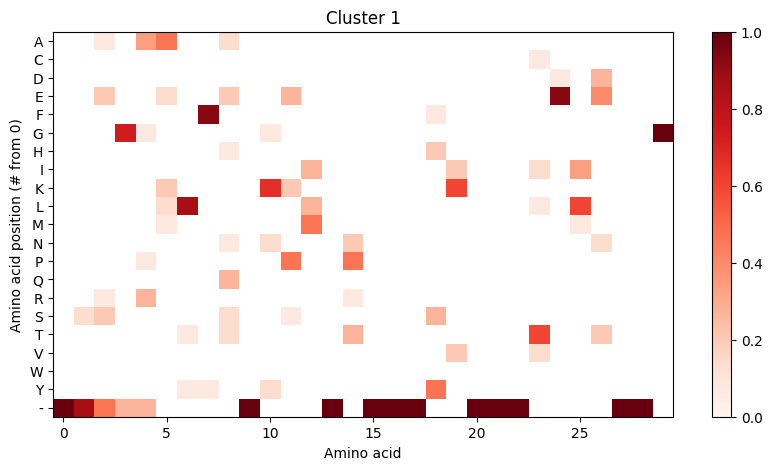

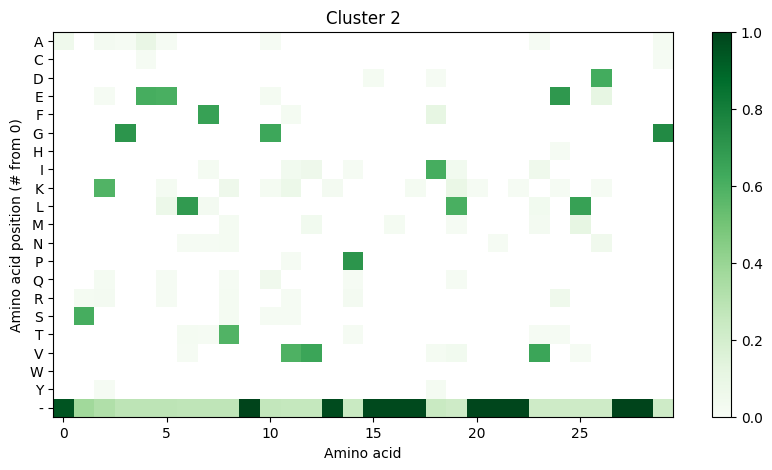

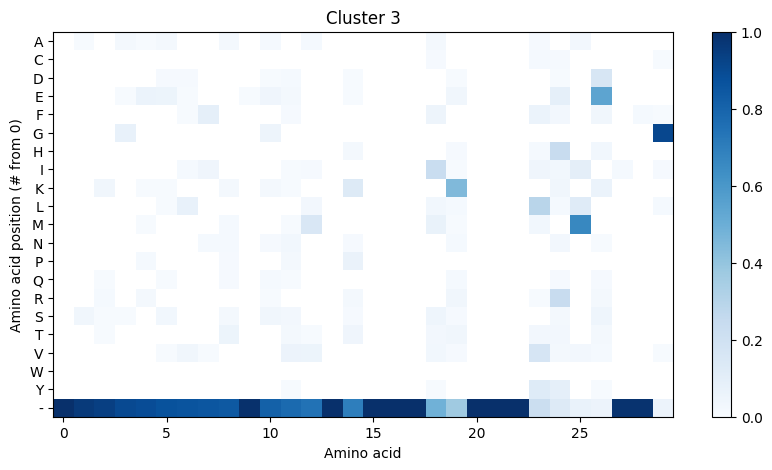

In [13]:
mu_data = cat_mix.mu_mix.copy()

colors = ["Reds", "Greens", "Blues"]

for i in range(3):
    f = implot(mu_data[i,:,:], i+1, 0, 30, colors[i])
    plt.show()

We can see that cluster 3 mainly comprises sequences that have almost exclusively blanks in the first 30
amino acids, while cluster 1 and 2 sequences may have blanks but are less likely to have exclusively blanks.
Cluster 2 predominantly consists of sequences that start with the sequence -SKGEELF (with some variations), while cluster 1 represents some more diverse variants.

And...that's basically it. There are some other functionalities not shown here -- the ability to predict the probability that a particular datapoint came from each cluster, for example, and most importantly the ability
to use multiprocessing + multithreading for large on-disk datasets when fitting, but these are the
basic capabilities.